# Modelling earthquake damage using machine learning

This notebook contains a benchmark analysis based on the benchmark blog post by DrivenData. The original analysis can be found here:
https://drivendata.co/blog/richters-predictor-benchmark/

The data is available from here:
https://www.drivendata.org/competitions/57/nepal-earthquake/

Start by importing libraries needed to import and explore the dataset.

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Define paths to the data and submissions folders.

In [2]:
DATA_DIR = Path('data', 'raw')
SUB_DIR = Path('submissions')

Load training features and training labels, using the building_id feature as the index column.

In [3]:
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='building_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='building_id')

## Exploratory Analysis

Check data types.

In [4]:
train_values.dtypes

geo_level_1_id                             int64
geo_level_2_id                             int64
geo_level_3_id                             int64
count_floors_pre_eq                        int64
age                                        int64
area_percentage                            int64
height_percentage                          int64
land_surface_condition                    object
foundation_type                           object
roof_type                                 object
ground_floor_type                         object
other_floor_type                          object
position                                  object
plan_configuration                        object
has_superstructure_adobe_mud               int64
has_superstructure_mud_mortar_stone        int64
has_superstructure_stone_flag              int64
has_superstructure_cement_mortar_stone     int64
has_superstructure_mud_mortar_brick        int64
has_superstructure_cement_mortar_brick     int64
has_superstructure_t

Check the shape of train values:

In [5]:
train_values.shape

(260601, 38)

Check for missing values:

In [14]:
print(train_values.isnull().sum())

geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo                 0
has_superstructure_rc_non_engine

Check the first rows of the dataset:

In [366]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


Plot the total number of buildings by damage type (label):

<Axes: title={'center': 'Number of Buildings per Damage Grade'}, xlabel='damage_grade'>

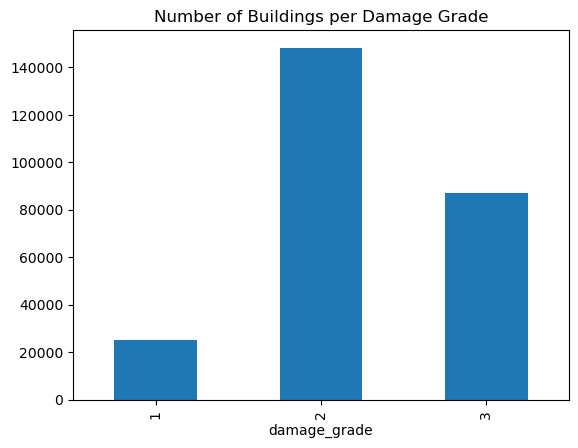

In [15]:
train_labels.damage_grade.value_counts().sort_index().plot(kind='bar', 
                                                           title="Number of Buildings per Damage Grade")

Plot the mean age by damage type:

<Axes: title={'center': 'Mean age of buildings per damage type'}, xlabel='damage_grade', ylabel='Mean age (years)'>

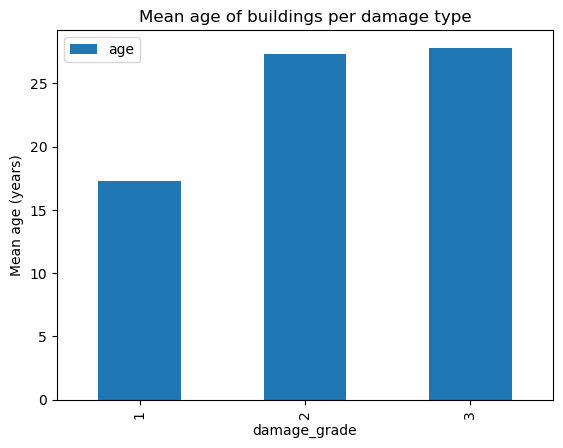

In [16]:
age_damage_data = pd.concat([train_values['age'],train_labels], axis=1)
age_damage_data.groupby('damage_grade').mean('age').plot(kind="bar", ylabel="Mean age (years)", title="Mean age of buildings per damage type")

Check for some variables that might have a lot of impact on the number of damaged buildings and type of damage, such as has_superstructure_rc_engineered (variable that indicates if the superstructure was made of engineered reinforced concrete):

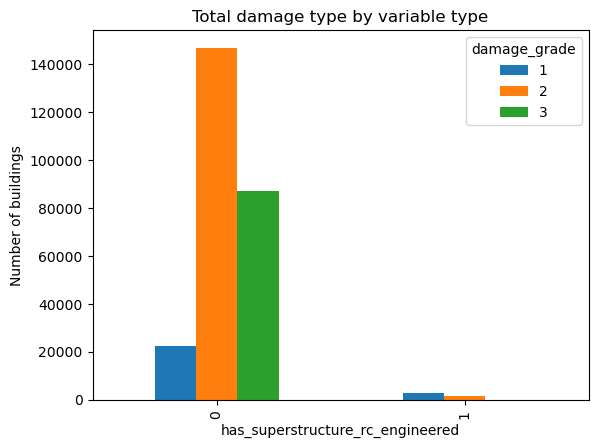

In [32]:
def plot_damage_by_variable(var_to_plot):
    var_data = pd.concat([train_values[var_to_plot],train_labels], axis=1)
    data_to_plot = var_data.groupby([var_to_plot,'damage_grade'])['damage_grade'].count().unstack()
    data_to_plot.plot(kind='bar', ylabel="Number of buildings", title="Total damage type by variable type")

var_to_plot = "has_superstructure_rc_engineered"
plot_damage_by_variable(var_to_plot)

Or houses with mud mortar - stone as superstructure:

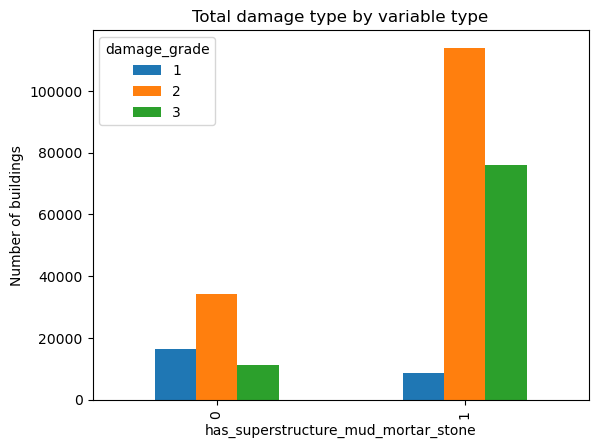

In [34]:
var_to_plot = "has_superstructure_mud_mortar_stone"
plot_damage_by_variable(var_to_plot)

Plot damage type by floor numbers:

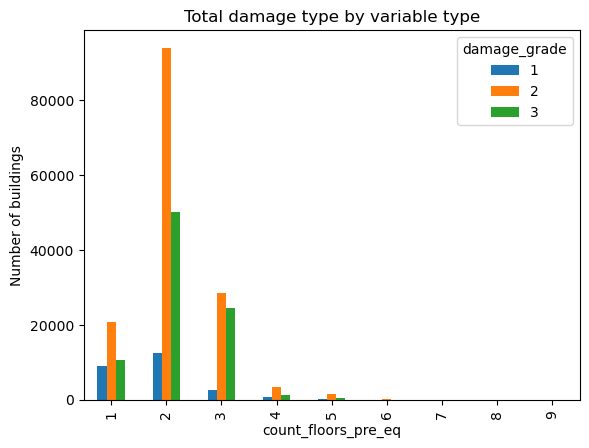

In [37]:
var_to_plot = "count_floors_pre_eq"
plot_damage_by_variable(var_to_plot)

Explore more widely by creating a pair-plot of some of the numeric features:

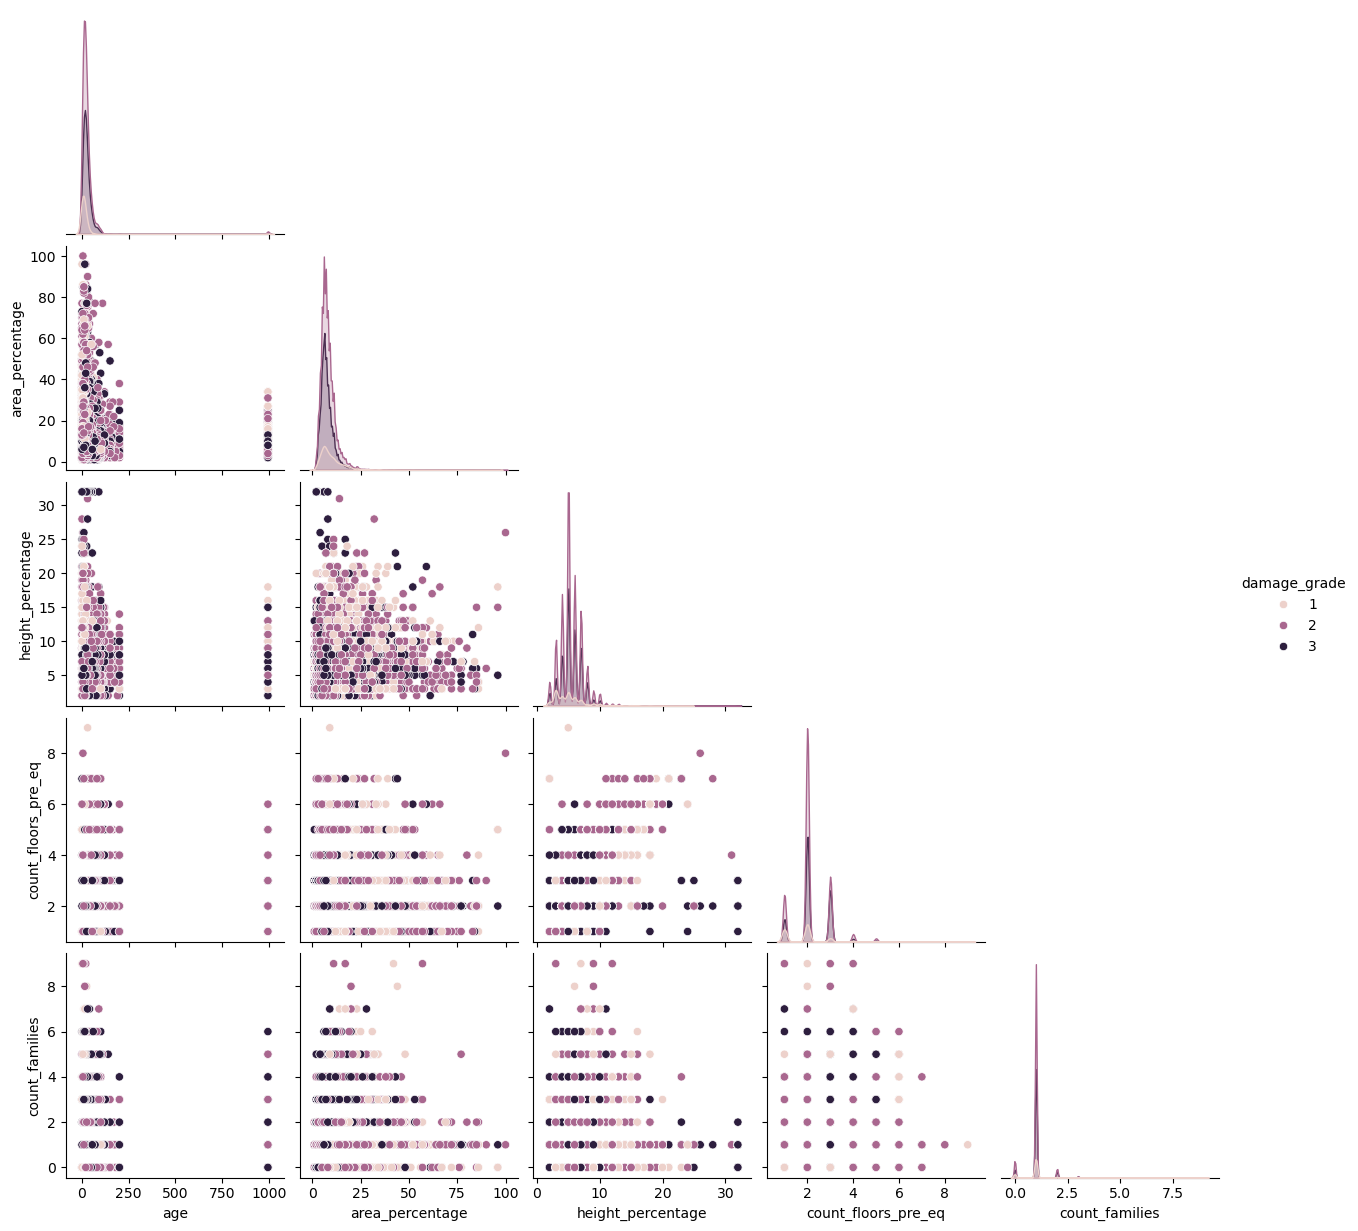

In [38]:
plot_features = ['age',
                'area_percentage', 
                'height_percentage',
                'count_floors_pre_eq',
                'count_families']

data_to_plot = train_values[plot_features]
data_to_plot = data_to_plot.join(train_labels)

sns.pairplot(data_to_plot, hue='damage_grade', corner=True)


## Benchmark classification model

Start by importing packages and functionality

In [61]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.linear_model import LogisticRegression

# for combining the preprocess with model training
from sklearn.pipeline import Pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import train_test_split

# evaluation metric (f1-score)
from sklearn.metrics import f1_score

Select numeric features for training model:

In [62]:
num_features = ['geo_level_1_id',
                'geo_level_2_id',
                'geo_level_3_id',
                'age',
                'area_percentage', 
                'height_percentage',
                'count_floors_pre_eq',
                'count_families']
features = num_features

train_values_num = train_values[features]

# create labels variable
labels = train_labels.damage_grade.to_numpy()

Before training the model, look at the correlation between features:

<Axes: >

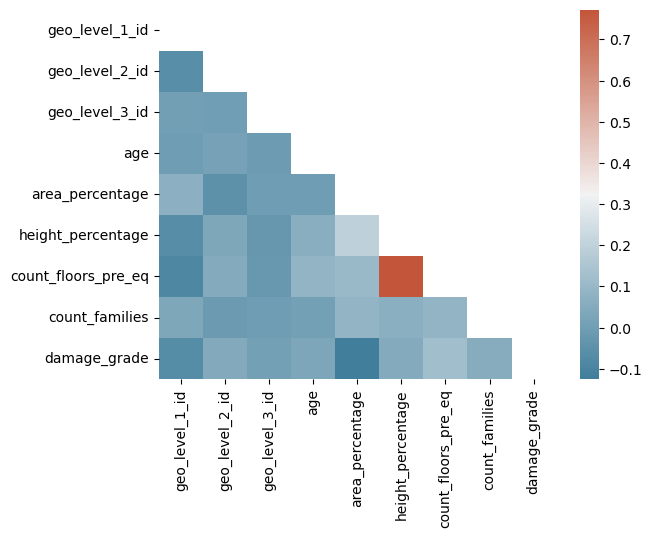

In [63]:
data_to_corr = train_values_num.join(train_labels)
corr = data_to_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap)

Create processing pipeline:

In [64]:
pipe = Pipeline([("scalar", StandardScaler()),
                ("classifier", LogisticRegression(random_state=0))])

Partition data into train and validation datasets (stratify classes):

In [65]:
X_train, X_val, y_train, y_val = train_test_split(train_values_num, labels, random_state=42, stratify=labels, test_size=0.2)

In [66]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier', LogisticRegression(random_state=0))])

Calculate F-score on training and validation data data:

In [69]:
# Training data F1-score
in_sample_preds = pipe.predict(X_train)
f1_score(y_train, in_sample_preds, average='micro')

0.5667977743668458

In [70]:
# Validation data F1-score
in_sample_preds = pipe.predict(X_val)
f1_score(y_val, in_sample_preds, average='micro')

0.5663552119107461

## Prepare and save submission

Some boilerplate code for running the model on the test dataset and saving the predictions for submission:

In [71]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='building_id')

test_values_subset = test_values[features]
predictions = pipe.predict(test_values_subset)

submission_format = pd.read_csv(SUB_DIR / 'submission_format.csv', index_col='building_id')

my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

my_submission.head()

my_submission.to_csv(SUB_DIR / 'submission.csv')